# Model inference

In the previous notebook, we saw how to do model inference on the test set. Here, we show how to load an already trained/fine-tuned model and a dataset and then do model inference.

In [1]:
# solve issue with autocomplete
%config Completer.use_jedi = False

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from mapreader import loader
from mapreader import classifier
from mapreader import load_patches
from mapreader import patchTorchDataset

import glob
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy.interpolate import griddata
from torchvision import transforms

try:
    import cartopy.crs as ccrs
    ccrs_imported = True
except ImportError:
    print(f"[WARNING] cartopy could not be imported!")
    print(f"[WARNING] cartopy is used for plotting the results on maps.")
    print(f"[WARNING] You can ignore this if you don't want to plot the results.")
    ccrs_imported = False

## Read patches (i.e., sliced images) and add metadata

First, we need to load a set of images/pathces. We use a CV model to do inference on these images.

In [14]:
mymaps = load_patches("./maps/slice_50_50/*101168192*PNG", 
                      parent_paths="./maps/map_101168192.png")

path2metadata = "./maps/metadata.csv"
mymaps.add_metadata(metadata=path2metadata)

In [15]:
# Calculate coordinates and some pixel stats
mymaps.add_center_coord()
mymaps.calc_pixel_stats()

[INFO] Add center coordinates, tree level: child
[INFO] Add coord-increments, tree level: parent
[INFO] Add shape, tree level: parent
----------
[INFO] calculate pixel stats for image: map_101168192.png


In [16]:
maps_pd, patches_pd = mymaps.convertImages(fmt="dataframe")
patches_pd.head()

parent_id  \
patch-1400-2550-1450-2600-#map_101168192.png#.PNG  map_101168192.png   
patch-2650-700-2700-750-#map_101168192.png#.PNG    map_101168192.png   
patch-1700-1650-1750-1700-#map_101168192.png#.PNG  map_101168192.png   
patch-2000-3450-2050-3500-#map_101168192.png#.PNG  map_101168192.png   
patch-4800-250-4850-300-#map_101168192.png#.PNG    map_101168192.png   

                                                                                          image_path  \
patch-1400-2550-1450-2600-#map_101168192.png#.PNG  /Users/rwood/LwM/MapReader/examples/geospatial...   
patch-2650-700-2700-750-#map_101168192.png#.PNG    /Users/rwood/LwM/MapReader/examples/geospatial...   
patch-1700-1650-1750-1700-#map_101168192.png#.PNG  /Users/rwood/LwM/MapReader/examples/geospatial...   
patch-2000-3450-2050-3500-#map_101168192.png#.PNG  /Users/rwood/LwM/MapReader/examples/geospatial...   
patch-4800-250-4850-300-#map_101168192.png#.PNG    /Users/rwood/LwM/MapReader/examples/geospatial...   

                                                   min_x  min_y  max_x  max_y  \
patch-1400-2550-1450-2600-#map_101168192.png#.PNG   1400   2550   1450   2600   
patch-2650-700-2700-750-#map_101168192.png#.PNG     2650    700   2700    750   
patch-1700-1650-1750-1700-#map_101168192.png#.PNG   1700   1650   1750   1700   
patch-2000-3450-2050-3500-#map_101168192.png#.PNG   2000   3450   2050   3500   
patch-4800-250-4850-300-#map_101168192.png#.PNG     4800    250   4850    300   

                                                   center_lon  center_lat  \
patch-1400-2550-1450-2600-#map_101168192.png#.PNG   -5.326557   51.901433   
patch-2650-700-2700-750-#map_101168192.png#.PNG     -5.218959   52.000251   
patch-1700-1650-1750-1700-#map_101168192.png#.PNG   -5.300733   51.949506   
patch-2000-3450-2050-3500-#map_101168192.png#.PNG   -5.274910   51.853359   
patch-4800-250-4850-300-#map_101168192.png#.PNG     -5.033890   52.024287   

                                                   mean_pixel_R  mean_pixel_G  \
patch-1400-2550-1450-2600-#map_101168192.png#.PNG      0.723106      0.712773   
patch-2650-700-2700-750-#map_101168192.png#.PNG        0.931724      0.926521   
patch-1700-1650-1750-1700-#map_101168192.png#.PNG      0.922607      0.917197   
patch-2000-3450-2050-3500-#map_101168192.png#.PNG      0.788237      0.780951   
patch-4800-250-4850-300-#map_101168192.png#.PNG        0.859427      0.855315   

                                                   mean_pixel_B  \
patch-1400-2550-1450-2600-#map_101168192.png#.PNG      0.654930   
patch-2650-700-2700-750-#map_101168192.png#.PNG        0.863620   
patch-1700-1650-1750-1700-#map_101168192.png#.PNG      0.860330   
patch-2000-3450-2050-3500-#map_101168192.png#.PNG      0.720278   
patch-4800-250-4850-300-#map_101168192.png#.PNG        0.793153   

                                                   mean_pixel_RGB  \
patch-1400-2550-1450-2600-#map_101168192.png#.PNG        0.696936   
patch-2650-700-2700-750-#map_101168192.png#.PNG          0.907288   
patch-1700-1650-1750-1700-#map_101168192.png#.PNG        0.900044   
patch-2000-3450-2050-3500-#map_101168192.png#.PNG        0.763155   
patch-4800-250-4850-300-#map_101168192.png#.PNG          0.835965   

                                                   mean_pixel_A  std_pixel_R  \
patch-1400-2550-1450-2600-#map_101168192.png#.PNG      1.000000     0.170652   
patch-2650-700-2700-750-#map_101168192.png#.PNG        1.000000     0.009059   
patch-1700-1650-1750-1700-#map_101168192.png#.PNG      1.000000     0.047664   
patch-2000-3450-2050-3500-#map_101168192.png#.PNG      0.999995     0.117723   
patch-4800-250-4850-300-#map_101168192.png#.PNG        1.000000     0.128642   

                                                   std_pixel_G  std_pixel_B  \
patch-1400-2550-1450-2600-#map_101168192.png#.PNG     0.177379     0.168536   
patch-2650-700-2700-750-#map_101168192.png#.PNG       0.009537     0.010698   
patch-1700-1650-1750-1700-#m

In `.add_metadata`:

```python
# remove duplicates using "name" column
if columns == None:
    columns = list(metadata_df.columns)

if ("name" in columns) and ("image_id" in columns):
    print(f"Both 'name' and 'image_id' columns exist! Use 'name' to index.")
    image_id_col = "name"
if "name" in columns:
    image_id_col = "name"
elif "image_id" in columns:
    image_id_col = "image_id"
else:
    raise ValueError("'name' or 'image_id' should be one of the columns.")
```

The dataframe should have either `name` or `image_id` column, and that column should be the image ID (NOT the path to the image).

In [17]:
# Rename image_path to image_id
# This is needed later (see `.add_metadata`)
patches_pd = patches_pd.reset_index()
patches_pd.rename(columns={"index": "image_id"}, 
                  inplace=True)
patches_pd.head()

image_id          parent_id  \
0  patch-1400-2550-1450-2600-#map_101168192.png#.PNG  map_101168192.png   
1    patch-2650-700-2700-750-#map_101168192.png#.PNG  map_101168192.png   
2  patch-1700-1650-1750-1700-#map_101168192.png#.PNG  map_101168192.png   
3  patch-2000-3450-2050-3500-#map_101168192.png#.PNG  map_101168192.png   
4    patch-4800-250-4850-300-#map_101168192.png#.PNG  map_101168192.png   

                                          image_path  min_x  min_y  max_x  \
0  /Users/rwood/LwM/MapReader/examples/geospatial...   1400   2550   1450   
1  /Users/rwood/LwM/MapReader/examples/geospatial...   2650    700   2700   
2  /Users/rwood/LwM/MapReader/examples/geospatial...   1700   1650   1750   
3  /Users/rwood/LwM/MapReader/examples/geospatial...   2000   3450   2050   
4  /Users/rwood/LwM/MapReader/examples/geospatial...   4800    250   4850   

   max_y  center_lon  center_lat  mean_pixel_R  mean_pixel_G  mean_pixel_B  \
0   2600   -5.326557   51.901433      0.723106      0.712773      0.654930   
1    750   -5.218959   52.000251      0.931724      0.926521      0.863620   
2   1700   -5.300733   51.949506      0.922607      0.917197      0.860330   
3   3500   -5.274910   51.853359      0.788237      0.780951      0.720278   
4    300   -5.033890   52.024287      0.859427      0.855315      0.793153   

   mean_pixel_RGB  mean_pixel_A  std_pixel_R  std_pixel_G  std_pixel_B  \
0        0.696936      1.000000     0.170652     0.177379     0.168536   
1        0.907288      1.000000     0.009059     0.009537     0.010698   
2        0.900044      1.000000     0.047664     0.049935     0.049710   
3        0.763155      0.999995     0.117723     0.122318     0.120087   
4        0.835965      1.000000     0.128642     0.129813     0.124468   

   std_pixel_RGB  std_pixel_A  
0       0.174823     0.000000  
1       0.032462     0.000000  
2       0.056618     0.000000  
3       0.123862     0.000136  
4       0.131213     0.000000

In [18]:
patches2infer = patches_pd[["image_path"]]
patches2infer

image_path
0     /Users/rwood/LwM/MapReader/examples/geospatial...
1     /Users/rwood/LwM/MapReader/examples/geospatial...
2     /Users/rwood/LwM/MapReader/examples/geospatial...
3     /Users/rwood/LwM/MapReader/examples/geospatial...
4     /Users/rwood/LwM/MapReader/examples/geospatial...
...                                                 ...
6882  /Users/rwood/LwM/MapReader/examples/geospatial...
6883  /Users/rwood/LwM/MapReader/examples/geospatial...
6884  /Users/rwood/LwM/MapReader/examples/geospatial...
6885  /Users/rwood/LwM/MapReader/examples/geospatial...
6886  /Users/rwood/LwM/MapReader/examples/geospatial...

[6887 rows x 1 columns]

In [19]:
# XXX TESTING
# patches2infer = patches2infer[:1000]

## Add patches to `patchTorchDataset`

In [20]:
# ------------------
# --- Transformation
# ------------------
# FOR INCEPTION
#resize2 = 299
# otherwise:
resize2 = 224

# mean and standard deviations of pixel intensities in 
# all the patches in 6", second edition maps
normalize_mean = 1 - np.array([0.82860442, 0.82515008, 0.77019864])
normalize_std = 1 - np.array([0.1025585, 0.10527616, 0.10039222])
# other options:
# normalize_mean = [0.485, 0.456, 0.406]
# normalize_std = [0.229, 0.224, 0.225]

data_transforms = {
    'val': transforms.Compose(
        [transforms.Resize(resize2),
        transforms.ToTensor(),
        transforms.Normalize(normalize_mean, normalize_std)
        ]),
}


In [21]:
patches2infer_dataset = patchTorchDataset(patches2infer, 
                                          transform=data_transforms["val"])


## Load a classifier (normally trained in notebook 003)

In [23]:
myclassifier = classifier(device="default")

# HERE, you need to load a model stored in ./models_tutorial/
# e.g., 
# myclassifier.load("./models_tutorial/checkpoint_10.pkl")
myclassifier.load("./models_tutorial/checkpoint_13.pkl")

[INFO] Device is set to cpu


In [24]:
# Add dataset to myclassifier
batch_size=64
myclassifier.add2dataloader(patches2infer_dataset, 
                            set_name="infer_test", 
                            batch_size=batch_size, 
                            shuffle=False, 
                            num_workers=0)

[INFO] added 'infer_test' dataloader with 6887 elements.


In [30]:
myclassifier.batch_info(set_name='infer_test')

[INFO] dataset: infer_test
#samples:    6887
#batch size: 64
#batches:    108



## Inference on `set_name`

In [25]:
myclassifier.inference(set_name="infer_test")

2023-02-06 13:51:23 JY5FK6W3K5 [INFO] infer_test -- 26/26 --     64/6887 (  0.9%) -- 
2023-02-06 13:51:31 JY5FK6W3K5 [INFO] infer_test -- 26/26 --    384/6887 (  5.6%) -- 
2023-02-06 13:51:40 JY5FK6W3K5 [INFO] infer_test -- 26/26 --    704/6887 ( 10.2%) -- 
2023-02-06 13:51:48 JY5FK6W3K5 [INFO] infer_test -- 26/26 --   1024/6887 ( 14.9%) -- 
2023-02-06 13:51:56 JY5FK6W3K5 [INFO] infer_test -- 26/26 --   1344/6887 ( 19.5%) -- 
2023-02-06 13:52:04 JY5FK6W3K5 [INFO] infer_test -- 26/26 --   1664/6887 ( 24.2%) -- 
2023-02-06 13:52:13 JY5FK6W3K5 [INFO] infer_test -- 26/26 --   1984/6887 ( 28.8%) -- 
2023-02-06 13:52:21 JY5FK6W3K5 [INFO] infer_test -- 26/26 --   2304/6887 ( 33.5%) -- 
2023-02-06 13:52:29 JY5FK6W3K5 [INFO] infer_test -- 26/26 --   2624/6887 ( 38.1%) -- 
2023-02-06 13:52:37 JY5FK6W3K5 [INFO] infer_test -- 26/26 --   2944/6887 ( 42.7%) -- 
2023-02-06 13:52:46 JY5FK6W3K5 [INFO] infer_test -- 26/26 --   3264/6887 ( 47.4%) -- 
2023-02-06 13:52:54 JY5FK6W3K5 [INFO] infer_test -- 26


## Plot sample results

In [26]:
myclassifier.class_names

{0: 'No', 1: 'rail space'}

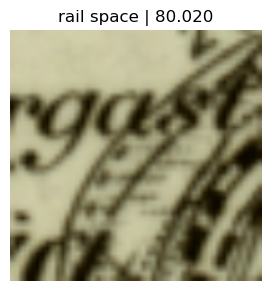

In [38]:
myclassifier.inference_sample_results(num_samples=8, class_index=1, set_name="infer_test", min_conf=80)

## Add model inference outputs to `mymaps`

In [ ]:
patches2infer['pred'] = myclassifier.pred_label
patches2infer['conf'] = np.max(np.array(myclassifier.pred_conf), 
                               axis=1)
patches2infer


In [ ]:
patches_pd = \
    patches_pd.merge(patches2infer, 
                     how="outer",
                     on="image_path",
                     validate="1:1")

In [ ]:
patches_pd.head()

In [ ]:
mymaps.add_metadata(patches_pd, 
                    tree_level="child")

## Write outputs as CSVs, one file per map sheet

In [40]:
maps_pd, patches_pd = mymaps.convertImages(fmt="dataframe")
patches_pd.head()

parent_id  \
patch-2450-2900-2500-2950-#map_101168609.png#.PNG  map_101168609.png   
patch-4150-1050-4200-1100-#map_101168609.png#.PNG  map_101168609.png   
patch-550-650-600-700-#map_101168609.png#.PNG      map_101168609.png   
patch-3950-2600-4000-2650-#map_101168609.png#.PNG  map_101168609.png   
patch-1850-2050-1900-2100-#map_101168609.png#.PNG  map_101168609.png   

                                                                                          image_path  \
patch-2450-2900-2500-2950-#map_101168609.png#.PNG  /Users/rwood/MapReader/examples/geospatial/cla...   
patch-4150-1050-4200-1100-#map_101168609.png#.PNG  /Users/rwood/MapReader/examples/geospatial/cla...   
patch-550-650-600-700-#map_101168609.png#.PNG      /Users/rwood/MapReader/examples/geospatial/cla...   
patch-3950-2600-4000-2650-#map_101168609.png#.PNG  /Users/rwood/MapReader/examples/geospatial/cla...   
patch-1850-2050-1900-2100-#map_101168609.png#.PNG  /Users/rwood/MapReader/examples/geospatial/cla...   

                                                   min_x  min_y  max_x  max_y  \
patch-2450-2900-2500-2950-#map_101168609.png#.PNG   2450   2900   2500   2950   
patch-4150-1050-4200-1100-#map_101168609.png#.PNG   4150   1050   4200   1100   
patch-550-650-600-700-#map_101168609.png#.PNG        550    650    600    700   
patch-3950-2600-4000-2650-#map_101168609.png#.PNG   3950   2600   4000   2650   
patch-1850-2050-1900-2100-#map_101168609.png#.PNG   1850   2050   1900   2100   

                                                   center_lon  center_lat  \
patch-2450-2900-2500-2950-#map_101168609.png#.PNG   -0.204436   51.528906   
patch-4150-1050-4200-1100-#map_101168609.png#.PNG   -0.058103   51.628378   
patch-550-650-600-700-#map_101168609.png#.PNG       -0.367985   51.649886   
patch-3950-2600-4000-2650-#map_101168609.png#.PNG   -0.075319   51.545036   
patch-1850-2050-1900-2100-#map_101168609.png#.PNG   -0.256083   51.574609   

                                                   mean_pixel_R  mean_pixel_G  \
patch-2450-2900-2500-2950-#map_101168609.png#.PNG      0.605147      0.586082   
patch-4150-1050-4200-1100-#map_101168609.png#.PNG      0.728422      0.721161   
patch-550-650-600-700-#map_101168609.png#.PNG          0.887780      0.889212   
patch-3950-2600-4000-2650-#map_101168609.png#.PNG      0.610921      0.587857   
patch-1850-2050-1900-2100-#map_101168609.png#.PNG      0.814306      0.809661   

                                                   ...  std_pixel_B  \
patch-2450-2900-2500-2950-#map_101168609.png#.PNG  ...     0.132151   
patch-4150-1050-4200-1100-#map_101168609.png#.PNG  ...     0.174584   
patch-550-650-600-700-#map_101168609.png#.PNG      ...     0.098972   
patch-3950-2600-4000-2650-#map_101168609.png#.PNG  ...     0.163135   
patch-1850-2050-1900-2100-#map_101168609.png#.PNG  ...     0.157199   

                                                   std_pixel_RGB  std_pixel_A  \
patch-2450-2900-2500-2950-#map_101168609.png#.PNG       0.135470          0.0   
patch-4150-1050-4200-1100-#map_101168609.png#.PNG       0.177836          0.0   
patch-550-650-600-700-#map_101168609.png#.PNG           0.100241          0.0   
patch-3950-2600-4000-2650-#map_101168609.png#.PNG       0.166580          0.0   
patch-1850-2050-1900-2100-#map_101168609.png#.PNG       0.157840          0.0   

                                                                                            image_id  \
patch-2450-2900-2500-2950-#map_101168609.png#.PNG  patch-2450-2900-2500-2950-#map_101168609.png#.PNG   
patch-4150-1050-4200-1100-#map_101168609.png#.PNG  patch-4150-1050-4200-1100-#map_101168609.png#.PNG   
patch-550-650-600-700-#map_101168609.png#.PNG          patch-550-650-600-700-#map_101168609.png#.PNG   
patch-3950-2600-4000-2650-#map_101168609.png#.PNG  patch-3950-2600-4000-2650-#map_101168609.png#.PNG   
patch-1850-2050-1900-2100-#map_101168609.png#.PNG  patch-1850-2050-1900-2100-#map_101168609.png#.PNG   

                         

In [41]:
output_dir = "./infer_output_tutorial"
os.makedirs(output_dir, exist_ok=True)

In [42]:
for one_map in list(maps_pd.index):
    # --- paths
    map_name = one_map.split(".")[0]
    patch2write = os.path.join(output_dir, f"patch_{map_name}.csv")
    sheet2write = os.path.join(output_dir, f"sheet_{map_name}.csv")
    # --- write outputs
    patches_pd[patches_pd["parent_id"] == one_map].to_csv(patch2write, index=False)
    maps_pd[maps_pd.index == one_map].to_csv(sheet2write, index=False)

## Load outputs and plot

Although we already have all the required dataframes/variables loaded, we re-load them here as this is a required step in most realistic applications.

In [43]:
mymaps = load_patches("./maps_tutorial/slice_50_50/*101168609*PNG", 
                      parent_paths="./maps_tutorial/*101168609*png")

# add metadata (using CSV files):
path2metadata = "./maps_tutorial/metadata.csv"
mymaps.add_metadata(metadata=path2metadata)

In [44]:
# load the CSV files which contain predictions/confidence/...
path2patch = glob.glob("./infer_output_tutorial/patch*101168609*csv")

for path2metadata in path2patch:
    print(path2metadata)
    mymaps.add_metadata(metadata=path2metadata, 
                        tree_level="child", 
                        delimiter=",")

# or directly:
# mymaps.add_metadata(patches_pd, tree_level="child")

./infer_output_tutorial/patch_map_101168609.csv


Other ways to read:

- Load dataframes, add metadata:

```python
mymaps_filt = loader()

mymaps_filt.loadDataframe(parents=maps_pd, 
                          children_df=patches_filt)

# add metadata (using CSV files):
path2metadata = "./maps_tutorial/metadata.csv"
mymaps_filt.add_metadata(metadata=path2metadata)
```

- Load CSV files

```python
from mapreader import loader

mymaps = loader()
mymaps.load_csv_file(parent_path="./infer_output_tutorial/sheet_map_101168609.csv", 
                     child_path="./infer_output_tutorial/patch_map_101168609.csv")
```

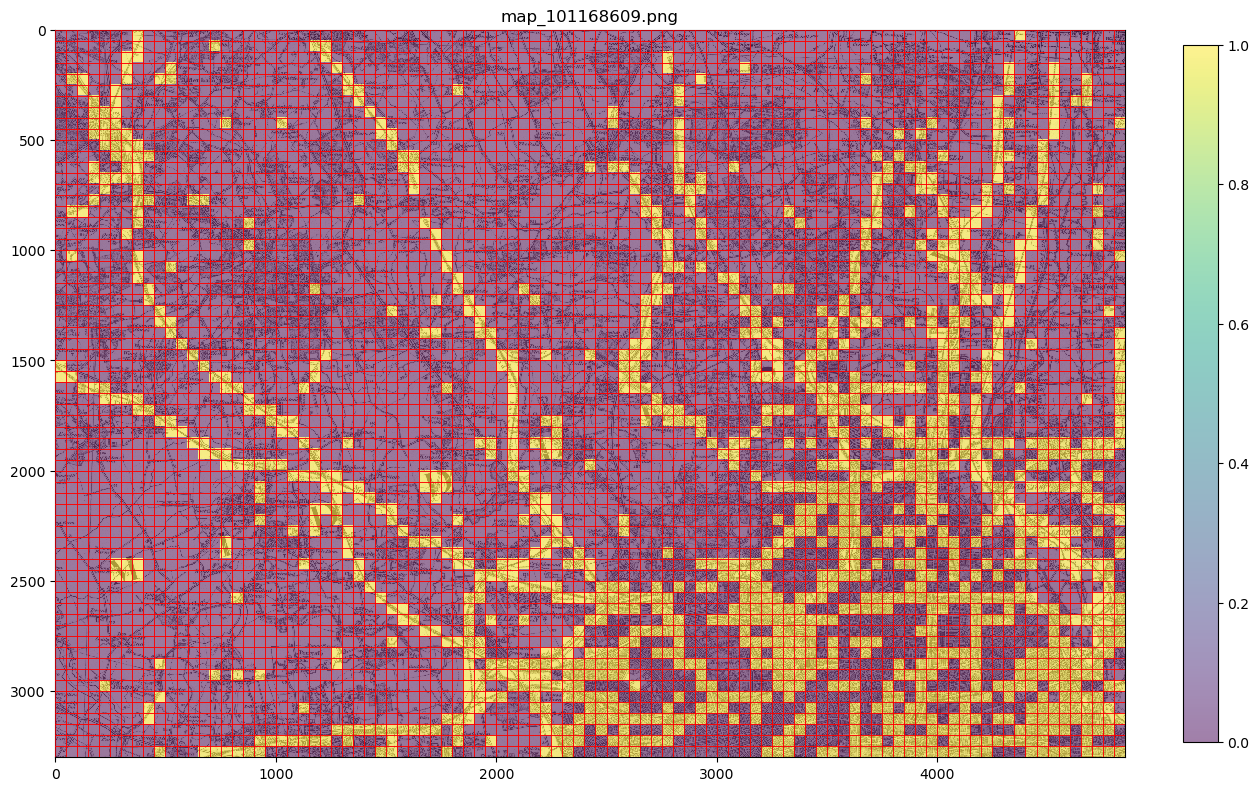

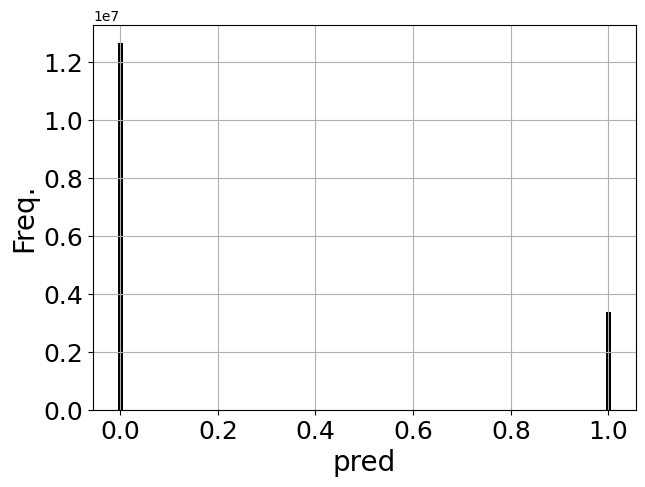

In [45]:
# List of all parents
all_parents = mymaps.list_parents()

mymaps.show_par(all_parents[0], 
                value="pred",
                border=True,
                plot_parent=True,
                vmin=0, vmax=1,
                figsize=(15, 15),
                alpha=0.5, 
                colorbar="viridis")

In [46]:
maps_pd, patches_pd = mymaps.convertImages(fmt="dataframe")
print(len(patches_pd))
patches_pd.head()

6402


parent_id  \
patch-2450-2900-2500-2950-#map_101168609.png#.PNG  map_101168609.png   
patch-4150-1050-4200-1100-#map_101168609.png#.PNG  map_101168609.png   
patch-550-650-600-700-#map_101168609.png#.PNG      map_101168609.png   
patch-3950-2600-4000-2650-#map_101168609.png#.PNG  map_101168609.png   
patch-1850-2050-1900-2100-#map_101168609.png#.PNG  map_101168609.png   

                                                                                          image_path  \
patch-2450-2900-2500-2950-#map_101168609.png#.PNG  /Users/rwood/MapReader/examples/geospatial/cla...   
patch-4150-1050-4200-1100-#map_101168609.png#.PNG  /Users/rwood/MapReader/examples/geospatial/cla...   
patch-550-650-600-700-#map_101168609.png#.PNG      /Users/rwood/MapReader/examples/geospatial/cla...   
patch-3950-2600-4000-2650-#map_101168609.png#.PNG  /Users/rwood/MapReader/examples/geospatial/cla...   
patch-1850-2050-1900-2100-#map_101168609.png#.PNG  /Users/rwood/MapReader/examples/geospatial/cla...   

                                                   min_x  min_y  max_x  max_y  \
patch-2450-2900-2500-2950-#map_101168609.png#.PNG   2450   2900   2500   2950   
patch-4150-1050-4200-1100-#map_101168609.png#.PNG   4150   1050   4200   1100   
patch-550-650-600-700-#map_101168609.png#.PNG        550    650    600    700   
patch-3950-2600-4000-2650-#map_101168609.png#.PNG   3950   2600   4000   2650   
patch-1850-2050-1900-2100-#map_101168609.png#.PNG   1850   2050   1900   2100   

                                                   center_lon  center_lat  \
patch-2450-2900-2500-2950-#map_101168609.png#.PNG   -0.204436   51.528906   
patch-4150-1050-4200-1100-#map_101168609.png#.PNG   -0.058103   51.628378   
patch-550-650-600-700-#map_101168609.png#.PNG       -0.367985   51.649886   
patch-3950-2600-4000-2650-#map_101168609.png#.PNG   -0.075319   51.545036   
patch-1850-2050-1900-2100-#map_101168609.png#.PNG   -0.256083   51.574609   

                                                   mean_pixel_R  mean_pixel_G  \
patch-2450-2900-2500-2950-#map_101168609.png#.PNG      0.605147      0.586082   
patch-4150-1050-4200-1100-#map_101168609.png#.PNG      0.728422      0.721161   
patch-550-650-600-700-#map_101168609.png#.PNG          0.887780      0.889212   
patch-3950-2600-4000-2650-#map_101168609.png#.PNG      0.610921      0.587857   
patch-1850-2050-1900-2100-#map_101168609.png#.PNG      0.814306      0.809661   

                                                   ...  std_pixel_B  \
patch-2450-2900-2500-2950-#map_101168609.png#.PNG  ...     0.132151   
patch-4150-1050-4200-1100-#map_101168609.png#.PNG  ...     0.174584   
patch-550-650-600-700-#map_101168609.png#.PNG      ...     0.098972   
patch-3950-2600-4000-2650-#map_101168609.png#.PNG  ...     0.163135   
patch-1850-2050-1900-2100-#map_101168609.png#.PNG  ...     0.157199   

                                                   std_pixel_RGB  std_pixel_A  \
patch-2450-2900-2500-2950-#map_101168609.png#.PNG       0.135470          0.0   
patch-4150-1050-4200-1100-#map_101168609.png#.PNG       0.177836          0.0   
patch-550-650-600-700-#map_101168609.png#.PNG           0.100241          0.0   
patch-3950-2600-4000-2650-#map_101168609.png#.PNG       0.166580          0.0   
patch-1850-2050-1900-2100-#map_101168609.png#.PNG       0.157840          0.0   

                                                                                            image_id  \
patch-2450-2900-2500-2950-#map_101168609.png#.PNG  patch-2450-2900-2500-2950-#map_101168609.png#.PNG   
patch-4150-1050-4200-1100-#map_101168609.png#.PNG  patch-4150-1050-4200-1100-#map_101168609.png#.PNG   
patch-550-650-600-700-#map_101168609.png#.PNG          patch-550-650-600-700-#map_101168609.png#.PNG   
patch-3950-2600-4000-2650-#map_101168609.png#.PNG  patch-3950-2600-4000-2650-#map_101168609.png#.PNG   
patch-1850-2050-1900-2100-#map_101168609.png#.PNG  patch-1850-2050-1900-2100-#map_101168609.png#.PNG   

                         

In [47]:
# filter patches with NaNs
patches_filt = patches_pd[~patches_pd["pred"].isna()]
patches_filt = patches_pd[patches_pd["pred"] >= 0]
patches_filt["pred"].value_counts()

0    5058
1    1344
Name: pred, dtype: int64

### other plots

In [48]:
patches_filt2plot = patches_filt[(patches_filt["mean_pixel_A"] > 0.01)]


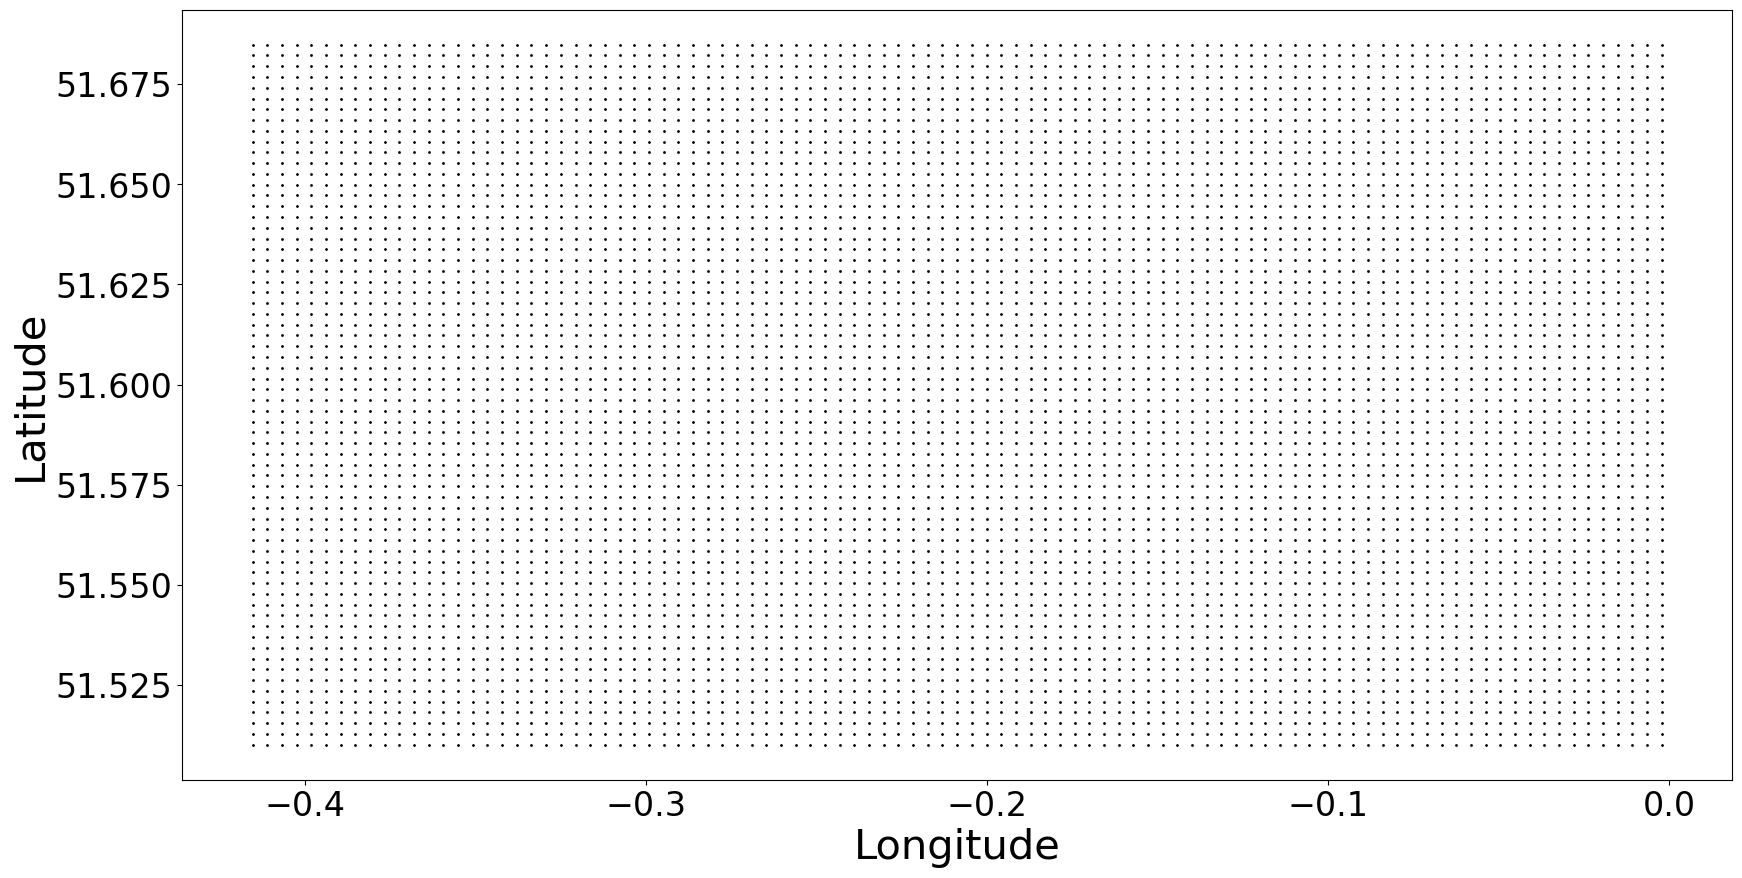

In [49]:
plt.figure(figsize=(20, 10))
plt.scatter(patches_filt2plot["center_lon"].values, 
            patches_filt2plot["center_lat"].values, 
            c="k",
            s=1)
plt.xlabel("Longitude", size=30)
plt.ylabel("Latitude", size=30)
plt.xticks(size=24)
plt.yticks(size=24)
plt.show()

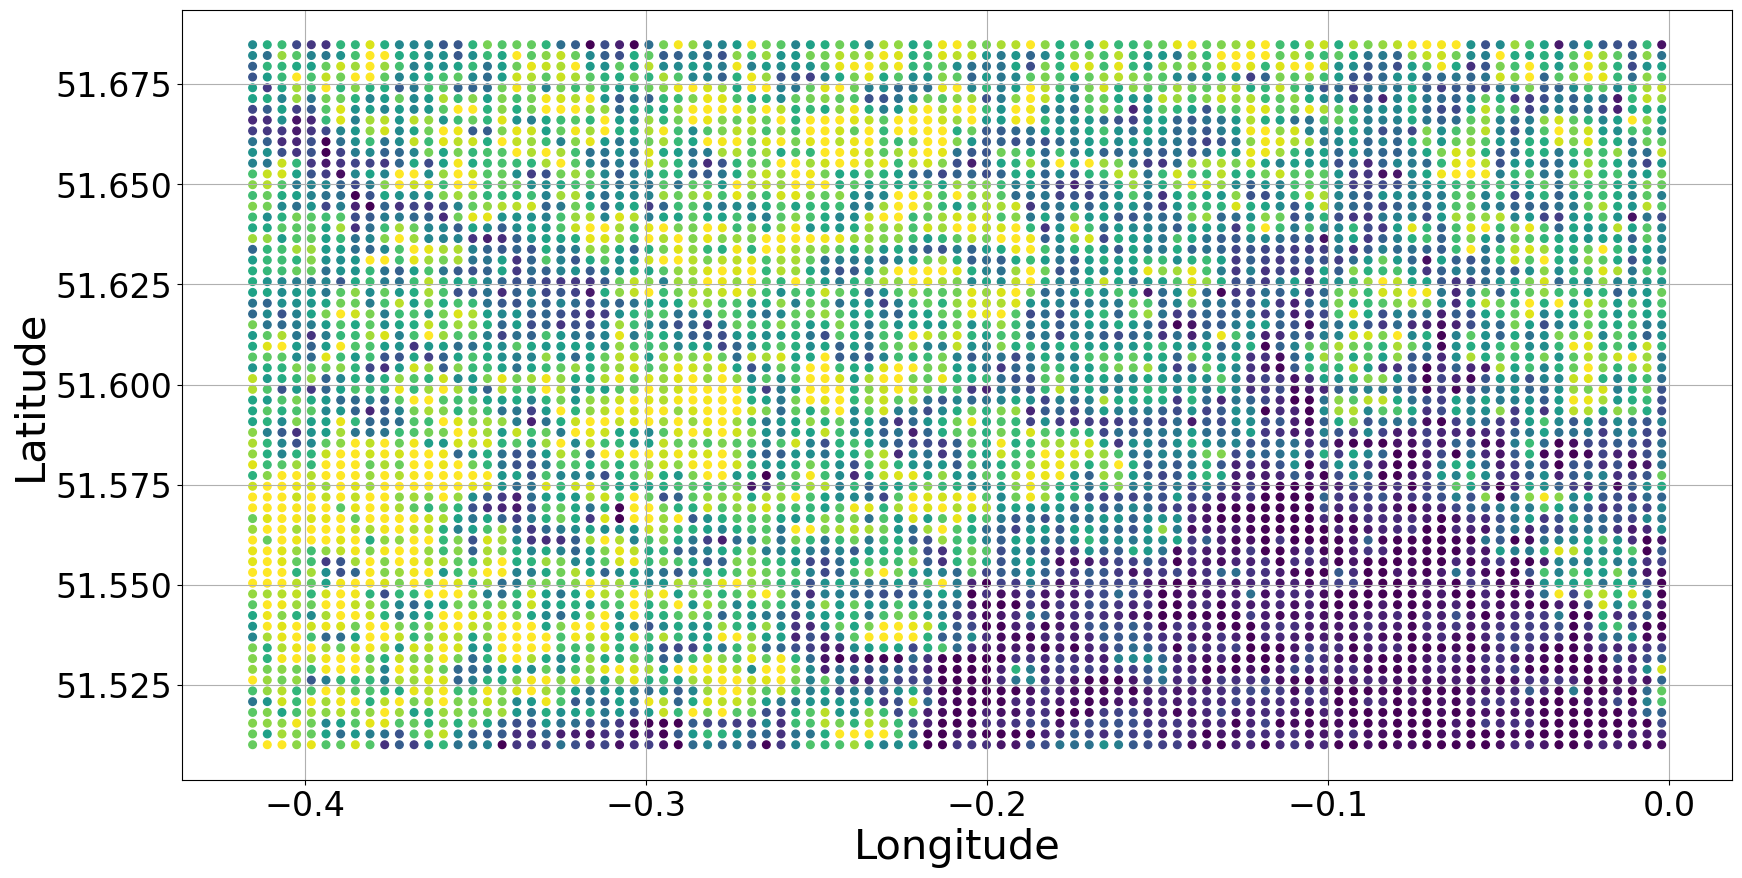

In [50]:
plt.figure(figsize=(20, 10))
plt.scatter(patches_filt2plot["center_lon"].values, 
            patches_filt2plot["center_lat"].values, 
            c=patches_filt2plot["mean_pixel_RGB"].values,
            vmin=0.6, vmax=0.9,
            s=30)
plt.xlabel("Longitude", size=30)
plt.ylabel("Latitude", size=30)
plt.xticks(size=24)
plt.yticks(size=24)
plt.grid()
plt.show()

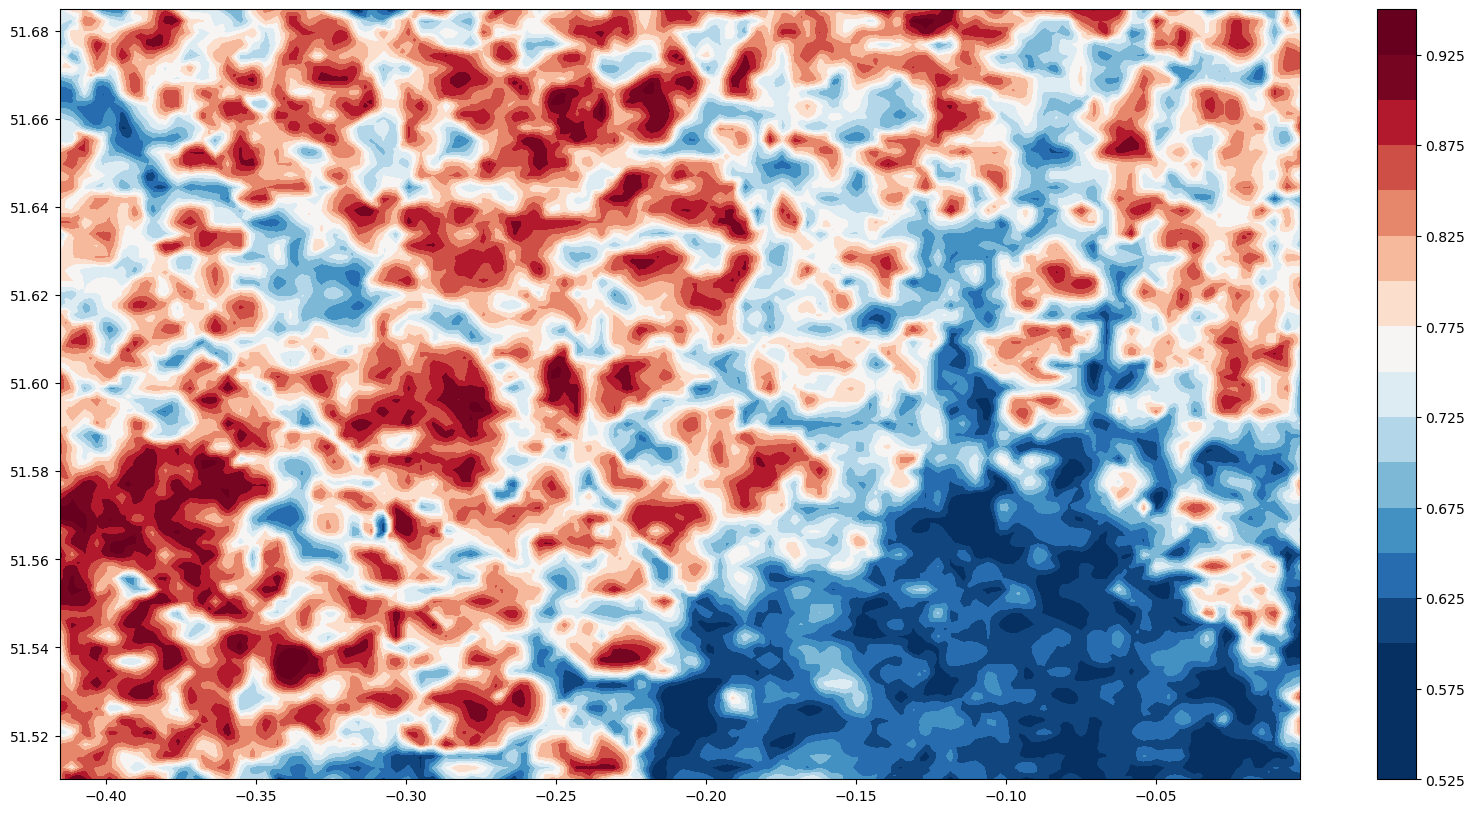

In [51]:
# inputs
vmin = 0.6
vmax = 0.92
levels = 15
ngridx = 200
ngridy = 200

grouped = patches_filt2plot.groupby("parent_id")

plt.figure(figsize=(20, 10))
for name, group in grouped:
    x = group["center_lon"].values
    y = group["center_lat"].values
    z = group["mean_pixel_RGB"].values

    # Create grid values first.
    xi = np.linspace(min(x), max(x), ngridx)
    yi = np.linspace(min(y), max(y), ngridy)
    zi = griddata((x, y), z, 
                  (xi[None, :], yi[:, None]), 
                  method='linear')

#     plt.contour(xi, yi, zi, 
#                 levels=levels, 
#                 linewidths=0.5, colors='k', 
#                 vmin=vmin, vmax=vmax)
    
    plt.contourf(xi, yi, zi, 
                 levels=levels, 
                 cmap="RdBu_r", 
                 vmin=vmin, vmax=vmax)
    
plt.colorbar()
plt.show()

# # Linearly interpolate the data (x, y) on a grid defined by (xi, yi).
# triang = tri.Triangulation(x, y)
# interpolator = tri.LinearTriInterpolator(triang, z)
# Xi, Yi = np.meshgrid(xi, yi)
# zi = interpolator(Xi, Yi)

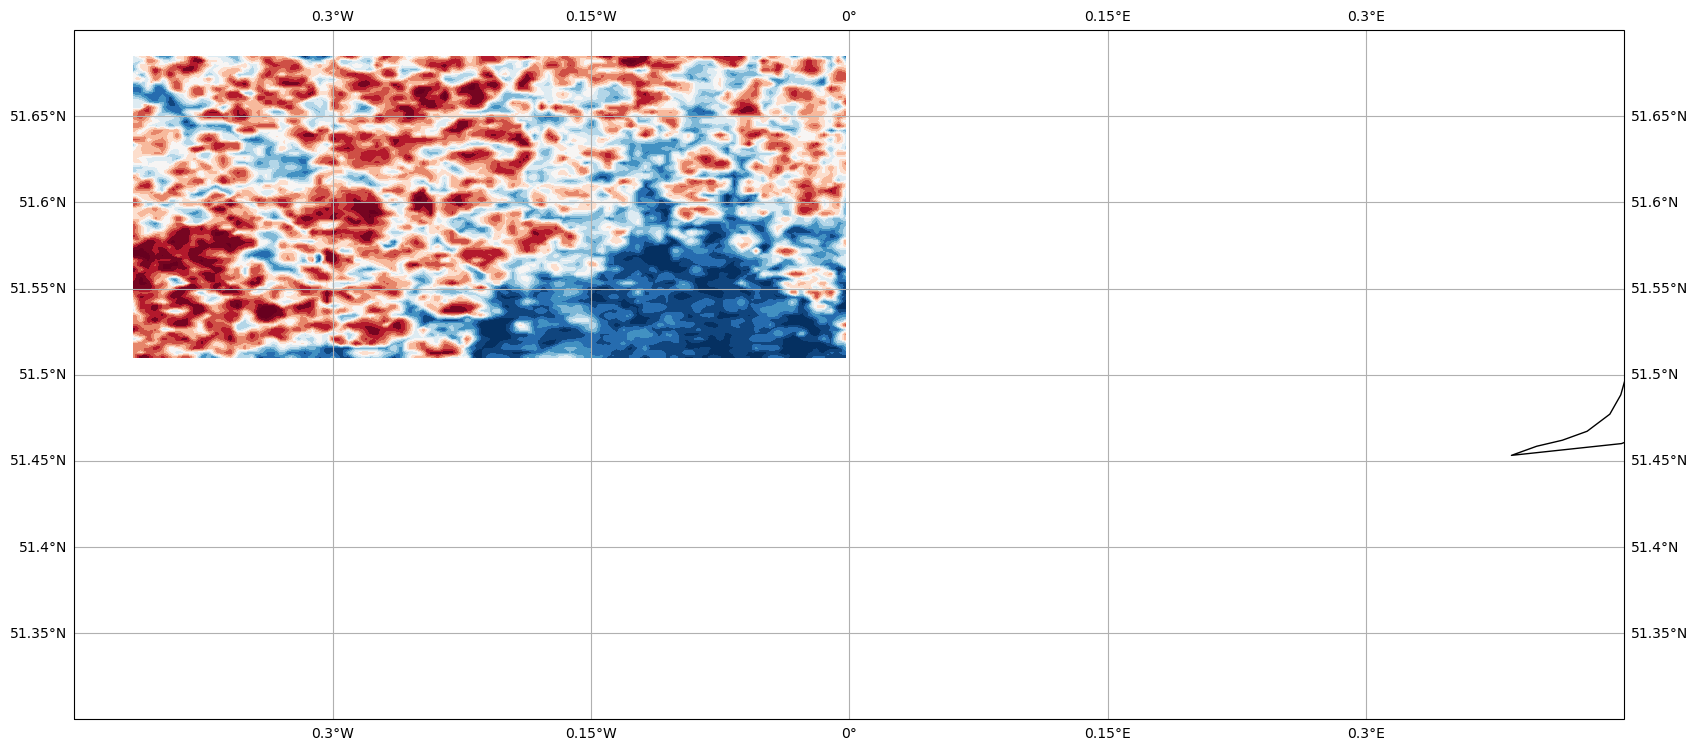

In [52]:
# inputs
vmin=0.6
vmax=0.92
levels=15
ngridx = 200
ngridy = 200

if ccrs_imported:
    grouped = patches_filt2plot.groupby("parent_id")

    fig = plt.figure(figsize=(20, 10))
    ax = plt.axes(projection=ccrs.PlateCarree())

    #extent = [-8.08999993, 1.81388127, 49.8338702, 60.95000002]
    extent = [-0.45, 0.45, 51.3, 51.7] # extracted from metadata

    ax.set_extent(extent)
    ax.coastlines(resolution='10m', color='black', linewidth=1)

    for name, group in grouped:
        x = group["center_lon"].values
        y = group["center_lat"].values
        z = group["mean_pixel_RGB"].values

        # Create grid values first.
        xi = np.linspace(min(x), max(x), ngridx)
        yi = np.linspace(min(y), max(y), ngridy)
        zi = griddata((x, y), z, 
                      (xi[None, :], yi[:, None]), 
                      method='linear')

    #     plt.contour(xi, yi, zi, 
    #                 levels=levels, 
    #                 linewidths=0.5, colors='k', 
    #                 vmin=vmin, vmax=vmax,
    #                 transform=ccrs.PlateCarree())

        plt.contourf(xi, yi, zi, 
                     levels=levels, 
                     cmap="RdBu_r", 
                     vmin=vmin, vmax=vmax,
                     transform=ccrs.PlateCarree())

    ax.gridlines(draw_labels=True)#, xlocs=[150, 152, 154, 155])
    plt.show()
else:
    print(f"[WARNING] cartopy could not be imported!")
    print(f"[WARNING] cartopy is used for plotting the results on maps.")
    print(f"[WARNING] You can ignore this if you don't want to plot the results.")